***FCIM.FIA - Fundamentals of Artificial Intelligence***
> **Lab 4:** Processing images with OpenCV and CNNs \
> **Performed by:** Dobrojan Alexandru, FAF-212 \
> **Verified by:** Elena Graur, asist. univ.


# Theory



A **kernel** (also called a filter or mask) is a small matrix used to modify an image through a process called convolution. The kernel is applied to an image to perform operations such as blurring, sharpening, edge detection, and more. A kernel is typically a small matrix, such as 3x3, 5x5, etc. It contains numerical values (weights) that determine how the surrounding pixels affect the center pixel. he kernel is moved over the image, and at each position, it performs a weighted sum of the pixel values it covers. This result replaces the center pixel, this is called **convolution**.

In [130]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Any, Sequence
from PIL import Image
import shutil

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

CvImg = cv.Mat | np.ndarray[Any, np.dtype]


## Task 1

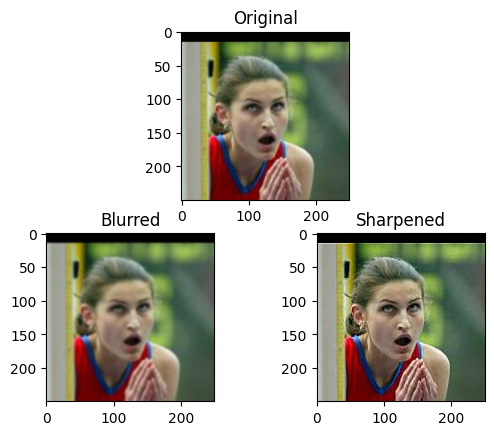

In [131]:
def load_image(file_name: str) -> CvImg:
   img = cv.imread(os.path.join('images', file_name))
   assert img is not None, f"{file_name} does not exist"
   return img


def map_to_rgb(img: CvImg) -> CvImg:
   return cv.cvtColor(img, cv.COLOR_BGR2RGB)


def blur_image(img: CvImg, ksize: int) -> CvImg:
   kernel = (ksize, ksize)
   blurred = cv.GaussianBlur(img, kernel, 0)
   return map_to_rgb(blurred)


def sharpen_image(img: CvImg) -> CvImg:
   kernel = np.array([[0, -1, 0],
                      [-1, 5, -1],
                      [0, -1, 0]])
   sharpened = cv.filter2D(img, -1, kernel)
   return map_to_rgb(sharpened)


original = load_image('0AA0A2.jpg')
blurred = blur_image(original, 5)
sharpened = sharpen_image(original)
original = map_to_rgb(original)

plt.subplot(2, 1, 1), plt.imshow(original), plt.title('Original')
plt.subplot(2, 2, 3), plt.imshow(blurred), plt.title('Blurred')
plt.subplot(2, 2, 4), plt.imshow(sharpened), plt.title('Sharpened')
plt.show()


## Task 2

In [132]:
def detect_face(img: CvImg) -> Sequence[Sequence[int]] | None:
   gray_image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
   classifier = cv.CascadeClassifier(
      cv.data.haarcascades + 'haarcascade_frontalface_default.xml'
   )
   face = classifier.detectMultiScale(
      gray_image, scaleFactor=1.1, minNeighbors=10, minSize=(130, 130)
   )

   if len(face) == 0:
      return None

   return face

## Task 3

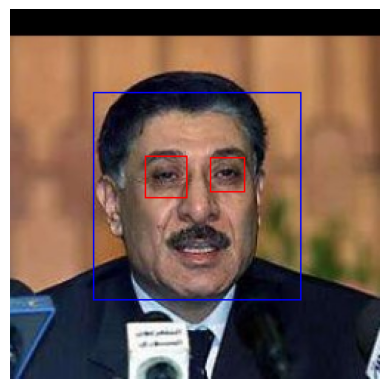

Eyes are on different levels (10px) for 4CA327.jpg


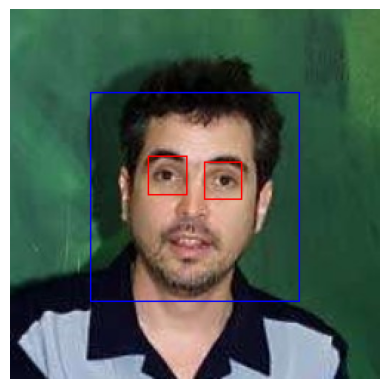

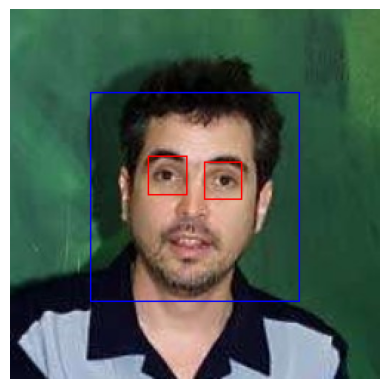

In [133]:


def is_grayscale(img: CvImg, threshold=2) -> bool:
   if len(img.shape) < 3 or img.shape[2] == 1:
      return True

   # get all 3 channels
   b, g, r = img[:, :, 0], img[:, :, 1], img[:, :, 2]

   # if all the pixels have equal colors of are very close
   return (abs(b - g) < threshold).all() and (abs(b - r) < threshold).all() and (abs(g - r) < threshold).all()


def is_portrait_or_square(img: CvImg) -> bool:
   w, h, c = img.shape
   return w <= h


def detect_eyes(img: CvImg) -> Sequence[Sequence[int]] | None:
   gray_image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
   classifier = cv.CascadeClassifier(
      cv.data.haarcascades + 'haarcascade_eye.xml'
   )
   eyes = classifier.detectMultiScale(
      gray_image, scaleFactor=1.1, minNeighbors=10, minSize=(10, 10)
   )

   if len(eyes) == 0:
      return None

   return eyes


def validate_eyes(file_name: str, eyes: Sequence[Sequence[int]]) -> bool:
   if eyes is None:
      print(f'No eyes detected for {file_name}')
      return False
   if len(eyes) != 2:
      print(f'Wrong number of eyes detected for {file_name}')
      return False
   eyes_diff = abs(eyes[0][1] - eyes[1][1])
   if eyes_diff > 5:
      print(f'Eyes are on different levels ({eyes_diff}px) for {file_name}')
      return False
   return True


def validate_face(file_name: str, face: Sequence[Sequence[int]], img) -> bool:
   if face is None:
      print(f'No face detected for {file_name}')
      return False
   if len(face) != 1:
      print(f'No face or more than 1 face detected for {file_name} ({len(face)})')
      return False
   ratio = (face[0][2] * face[0][3]) / (img.shape[0] * img.shape[1])
   if ratio < 0.2:
      print(f'Face surface is smaller than 20% of image for {file_name}')
      return False
   if ratio > 0.5:
      print(f'Face surface is larger than 50% of image for {file_name}')
      return False
   return True


file_names = ['33C8EE.jpg', '4CA327.jpg', '7E0875.jpg', '7E0875.jpg']

for file_name in file_names:
   img = load_image(file_name)

   if is_grayscale(img, 2):
      print(f'{file_name} is grayscale')
      continue

   if not is_portrait_or_square(img):
      print(f'{file_name} is not of portrait of scale ratio')
      continue

   face = detect_face(img)
   if not validate_face(file_name, face, img):
      continue

   eyes = detect_eyes(img)
   if not validate_eyes(file_name, eyes):
      continue

   for (x, y, w, h) in eyes:
      cv.rectangle(img, (x, y), (x + w, y + h), (0x00, 0x00, 0xff), 1)

   for (x, y, w, h) in face:
      cv.rectangle(img, (x, y), (x + w, y + h), (0xff, 0x00, 0x00), 1)

   img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
   plt.imshow(img_rgb)
   plt.axis('off')
   plt.show()


## Task 4

In [134]:

df = pd.read_csv('labels.csv')
df = df.sample(frac=1).reset_index(drop=True)

train_df_size = int(len(df) * 0.65)
train_df: pd.DataFrame = df[0:train_df_size]

validation_df_size = int(len(df) * 0.20)
validation_df_start = train_df_size
validation_df_end = validation_df_start + validation_df_size
validation_df: pd.DataFrame = df[train_df_size:validation_df_end]

test_df_size = int(len(df) * 0.20)
test_df_start = validation_df_end
test_df_end = test_df_start + test_df_size
test_df: pd.DataFrame = df[test_df_start:test_df_end]

DATASETS_PATH = 'datasets'
TRAIN_DATA_PATH = 'datasets/train'
TEST_DATA_PATH = 'datasets/test'
VALIDATION_DATA_PATH = 'datasets/validation'

if not os.path.exists(DATASETS_PATH):
   mode = 0o777
   os.mkdir(DATASETS_PATH, mode)

   for path in [TRAIN_DATA_PATH, TEST_DATA_PATH, VALIDATION_DATA_PATH]:
      os.mkdir(path, mode)
      os.mkdir(f'{path}/good', mode)
      os.mkdir(f'{path}/bad', mode)

   for df, dataset_path in [(train_df, TRAIN_DATA_PATH), (test_df, TEST_DATA_PATH),
                            (validation_df, VALIDATION_DATA_PATH)]:
      for index, row in df.iterrows():
         path = row['new_path']
         label = row['label']
         shutil.copy(path, f'{dataset_path}/{"good" if label is True else "bad"}')

else:
   print(f'{DATASETS_PATH} folder already exists')


datasets folder already exists


## Task 5

In [135]:
transform = transforms.Compose([
   transforms.Resize(250),
   transforms.CenterCrop(250),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = ImageFolder(root=TRAIN_DATA_PATH, transform=transform)
train_loader = DataLoader(train_dataset, num_workers=2)

test_dataset = ImageFolder(root=TEST_DATA_PATH, transform=transform)
test_loader = DataLoader(test_dataset, num_workers=2)

validation_dataset = ImageFolder(root=VALIDATION_DATA_PATH, transform=transform)
validation_loader = DataLoader(validation_dataset, num_workers=2)
class_names = ['good', 'bad']


class NeuralNet(nn.Module):
   def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 6, 5)
      self.pool = nn.MaxPool2d(2, 2)
      self.conv2 = nn.Conv2d(6, 16, 5)
      self.fc1 = nn.Linear(16 * 59 * 59, 120)  # Updated for 250x250 input
      self.fc2 = nn.Linear(120, 84)
      self.fc3 = nn.Linear(84, 2)

   def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = torch.flatten(x, 1)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

In [136]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Running on {device}')
net = NeuralNet().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(15):
   print(f'Epoch {epoch}')

   running_loss = 0.0

   for i, data in enumerate(train_loader):
      inputs, labels = data
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

   print(f'Loss: {running_loss / len(train_loader):.4f}')

torch.save(net.state_dict(), 'trained_net.pth')

Running on cpu
Epoch 0
Loss: 0.7492
Epoch 1
Loss: 0.6582
Epoch 2
Loss: 0.6539
Epoch 3
Loss: 0.6411
Epoch 4
Loss: 0.6330
Epoch 5
Loss: 0.6273
Epoch 6
Loss: 0.6184
Epoch 7
Loss: 0.6141
Epoch 8
Loss: 0.6047
Epoch 9
Loss: 0.5895
Epoch 10
Loss: 0.5656
Epoch 11
Loss: 0.5538
Epoch 12
Loss: 0.4711
Epoch 13
Loss: 0.4687
Epoch 14
Loss: 0.4086


In [137]:
# net = NeuralNet()
# net.load_state_dict(torch.load('trained_net.pth', weights_only=True))

In [138]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(test_loader)} test images: {100 * correct // total} %')

Accuracy of the network on the 8 test images: 87 %
